In [11]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.quantum_info import Operator
import math
import cmath
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

- Get simulator

In [12]:
SIM = Aer.get_backend('qasm_simulator')

## Build Traditional Function

- VQC-based SoftMax

[0.36670248+0.j 0.60459018+0.j 0.60459018+0.j 0.36670248+0.j]


<BarContainer object of 4 artists>

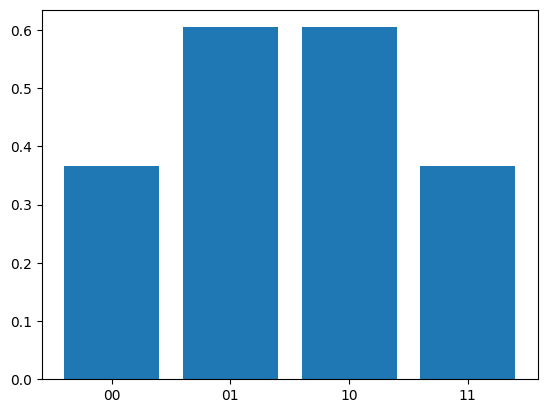

In [13]:
def softmaxVQC(args):
    # param:
    # args: {
    #
    # }
    vec = args["data"]
    arr = np.zeros(len(vec),dtype = np.complex_)
    sum = 0
    for item in vec:
        sum += cmath.e ** item
    for i in range(len(vec)):
        arr[i] = cmath.sqrt(cmath.e ** vec[i] / sum)
    return arr

args = {
    "data" : [-0.5, 0.5, 0.5, -0.5]
}
arr = softmaxVQC(args)
print(arr)
x = ["00", "01", "10", "11"]
plt.bar(x, arr)

- VQC-based sigmoid (Improved SoftMax

[0.00140992+0.j 0.70710538+0.j 0.70710538+0.j 0.00140992+0.j]


<BarContainer object of 4 artists>

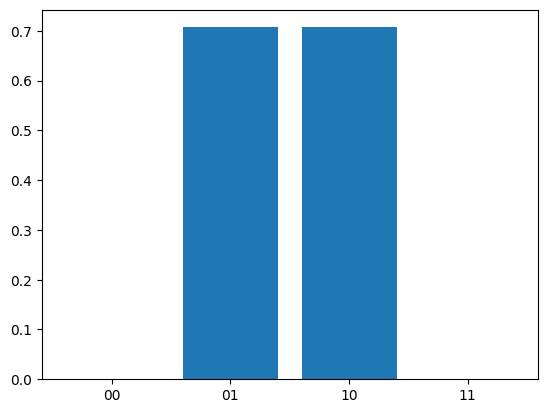

In [14]:
def sigmoidVQC(args):
    vec = args["data"]
    arr = np.zeros(len(vec),dtype = np.complex_)
    for i in range(len(vec)):
        arr[i] = 100 / (1 + cmath.sqrt(cmath.e ** (-vec[i])))
    args["data"] = arr
    return softmaxVQC(args)
    
args = {
    "data" : [-0.5, 0.5, 0.5, -0.5]
}
arr = sigmoidVQC(args)
print(arr)
x = ["00", "01", "10", "11"]
plt.bar(x, arr)

- VQC-based ReLU

[0.57735027 0.         0.57735027 0.57735027]


<BarContainer object of 4 artists>

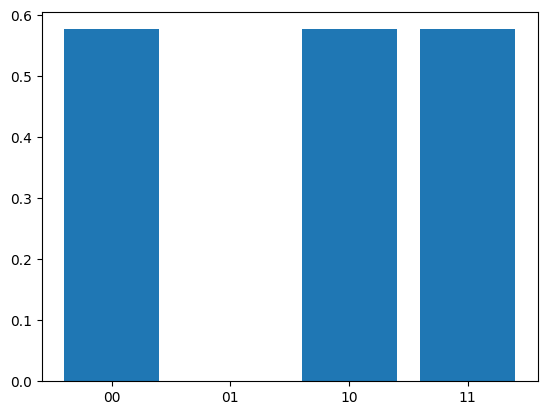

In [15]:
def reluVQC(args):
    vec = args["data"]
    n = len(args["markedState"])
    arr = np.zeros(len(vec))
    for i in range(len(vec)):
        if vec[i] > 0:
            arr[i] = 1 / math.sqrt(n)
        else:
            arr[i] = 0
    return arr

args = {
    "markedState": ["00", "11", "10"],
    "data" : [0.5, -0.5, 0.5, 0.5]
}
arr = reluVQC(args)
print(arr)
x = ["00", "01", "10", "11"]
plt.bar(x, arr)

## Build circuit components

- Build superposition

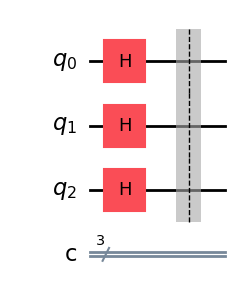

In [20]:
def initQC(n):
    # params: n -- num of qubits
    qc = QuantumCircuit(n, n)

    for i in range(n):
        qc.h(i)
    qc.barrier() # differentiate area

    return qc

qc = initQC(3)
qc.draw(output='mpl')

- Build Grover's Oracle according to the marked states
  - The code is from https://mqt.readthedocs.io/projects/ddsim/en/latest/Primitives.html

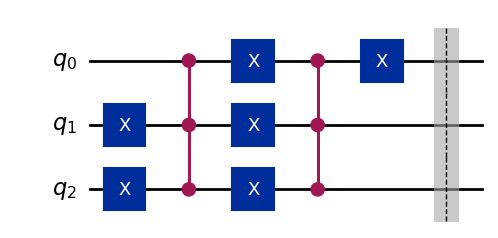

In [21]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    qc.barrier()
    return qc

marked_states = ["001", "110"]
qc = grover_oracle(marked_states)
qc.draw(output='mpl')

- Build ReverseGate

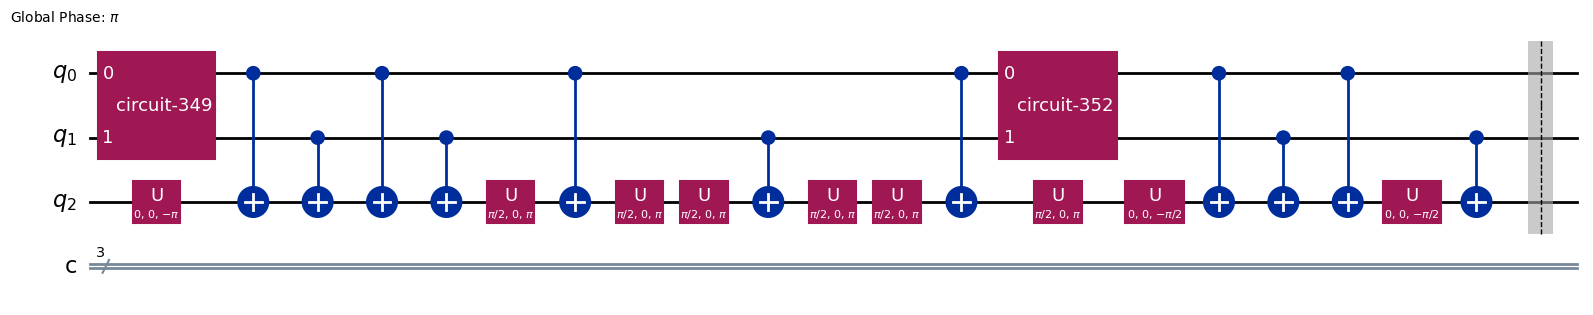

In [25]:
def buildRev(n):
    # params: n -- num of qubits
    qc = QuantumCircuit(n, n)
    qcIndex = list(range(n))
    mat = np.zeros((2**n, 2**n))
    np.fill_diagonal(mat, -1)
    RevGate = Operator(mat)
    qc.append(RevGate, qcIndex)
    qc.barrier()
    return qc

qc = buildRev(3)
qc.decompose().draw(output='mpl')

- Build processed state vector measurements

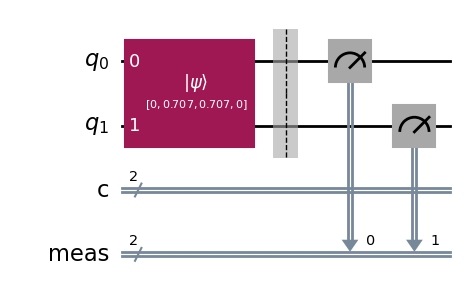

In [29]:
def measurement(n, statevector):
    qc = QuantumCircuit(n, n)
    qc.initialize(statevector.data)
    qc.measure_all()

    return qc

statevector = Statevector([0, 1 / math.sqrt(2), 1 / math.sqrt(2), 0])
qc = measurement(2, statevector)
qc.draw(output='mpl')

## Compose the circuit

In [31]:
def composeCircuit(n, oracle, marked_state, func):
    qc = QuantumCircuit(n, n)
    initial = initQC(n)
    rev = buildRev(n)
    qc = qc.compose(initial)
    qc = qc.compose(oracle)
    qc = qc.compose(rev)
    statevector = Statevector.from_instruction(qc)
    args = {}
    args["markedState"] = marked_state
    args["data"] = statevector.data
    statevector = Statevector(func(args))
    return statevector

## Run Simulation

- Simulation function

In [36]:
def simulate(qc, shots, backend):
    sampler = Sampler(backend=backend)
    sampler.options.default_shots = shots
    result = sampler.run([qc]).result()
    # print(result)
    dist = result[0].data.meas.get_counts()
    return dist

- Simulation on Softmax

/tmp/ipykernel_4616/2601119060.py:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


Statevector([0.31534242-2.09409014e-16j, 0.31534242-7.37451013e-17j,
             0.31534242-7.81213565e-17j, 0.44908514+2.51590982e-16j,
             0.31534242-7.37451013e-17j, 0.31534242-2.09409014e-16j,
             0.44908514+2.56452082e-16j, 0.31534242-7.90842033e-17j],
            dims=(2, 2, 2))


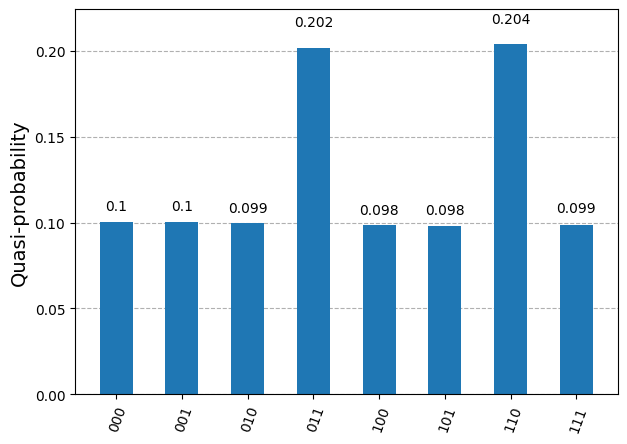

In [39]:
marked_states = ["110", "011"]
oracle = grover_oracle(marked_states)
statevector = composeCircuit(3, oracle, marked_states, softmaxVQC)
qc = measurement(3, statevector)
dist = simulate(qc, 100000, SIM)
print(statevector)
plot_distribution(dist)

- Simulation on Sigmoid

/tmp/ipykernel_4616/2601119060.py:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


Statevector([0.00861078-1.31285879e-16j, 0.00861078-8.53400689e-17j,
             0.00861078-8.68221918e-17j, 0.70694948-4.37573694e-17j,
             0.00861078-8.53400689e-17j, 0.00861078-1.31285879e-16j,
             0.70694948+5.11534539e-17j, 0.00861078-8.71482828e-17j],
            dims=(2, 2, 2))


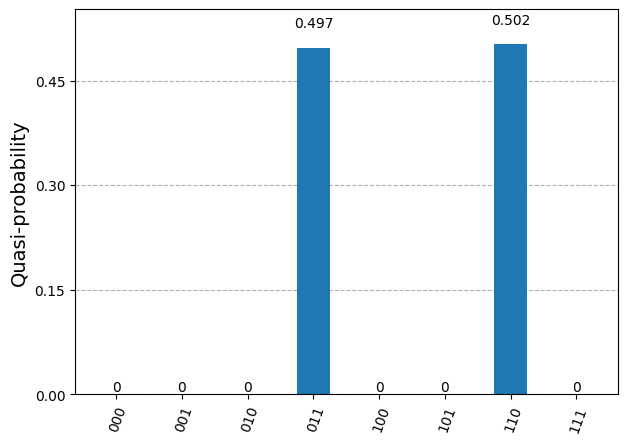

In [40]:
marked_states = ["110", "011"]
oracle = grover_oracle(marked_states)
statevector = composeCircuit(3, oracle, marked_states, sigmoidVQC)
qc = measurement(3, statevector)
dist = simulate(qc, 100000, SIM)
print(statevector)
plot_distribution(dist)

- Simulation on ReLU

/tmp/ipykernel_4616/2601119060.py:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.        +0.j],
            dims=(2, 2, 2))


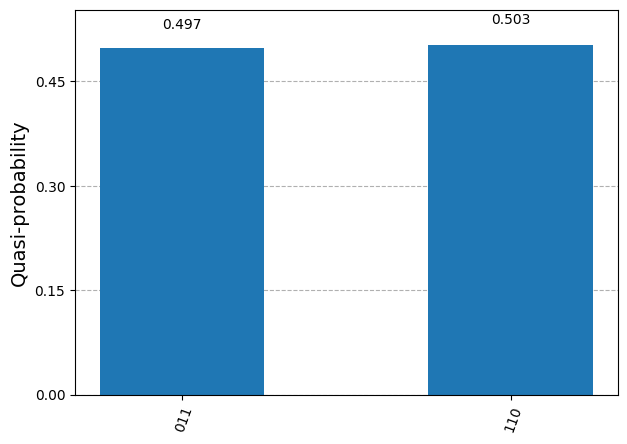

In [41]:
marked_states = ["110", "011"]
oracle = grover_oracle(marked_states)
statevector = composeCircuit(3, oracle, marked_states, reluVQC)
qc = measurement(3, statevector)
dist = simulate(qc, 100000, SIM)
print(statevector)
plot_distribution(dist)